## Import & Data check

In [33]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter

plt.style.use('seaborn')
sns.set(font_scale=1.5)

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [34]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [35]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [36]:
df_train.shape, df_test.shape

((8693, 14), (4277, 13))

In [37]:
numerical_feats = df_train.dtypes[df_train.dtypes != 'object'].index
print('Number of Numerical features: ', len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == 'object'].index
print('Number of Categorical features: ', len(categorical_feats))

Number of Numerical features:  7
Number of Categorical features:  7


In [38]:
print(df_train[numerical_feats].columns)
print('*'*80)
print(df_train[categorical_feats].columns)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported'],
      dtype='object')
********************************************************************************
Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Name'],
      dtype='object')


### 이상치 탐색 및 제거

In [39]:
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers
        
Outliers_to_drop = detect_outliers(df_train, 2, ['Age', 'RoomService', 'FoodCourt', 
                                                 'ShoppingMall', 'Spa', 'VRDeck'])

In [40]:
## 이상치 발견되지 않음
df_train.loc[Outliers_to_drop]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported


### 결측치 확인

In [41]:
for col in df_train.columns:
    msperc= 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() /df_train[col].shape[0]))
    print(msperc)

column: PassengerId	 Percent of NaN value: 0.00%
column: HomePlanet	 Percent of NaN value: 2.31%
column:  CryoSleep	 Percent of NaN value: 2.50%
column:      Cabin	 Percent of NaN value: 2.29%
column: Destination	 Percent of NaN value: 2.09%
column:        Age	 Percent of NaN value: 2.06%
column:        VIP	 Percent of NaN value: 2.34%
column: RoomService	 Percent of NaN value: 2.08%
column:  FoodCourt	 Percent of NaN value: 2.11%
column: ShoppingMall	 Percent of NaN value: 2.39%
column:        Spa	 Percent of NaN value: 2.11%
column:     VRDeck	 Percent of NaN value: 2.16%
column:       Name	 Percent of NaN value: 2.30%
column: Transported	 Percent of NaN value: 0.00%


In [42]:
for col in df_test.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100*(df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msperc)

column: PassengerId	 Percent of NaN value: 0.00%
column: HomePlanet	 Percent of NaN value: 2.03%
column:  CryoSleep	 Percent of NaN value: 2.17%
column:      Cabin	 Percent of NaN value: 2.34%
column: Destination	 Percent of NaN value: 2.15%
column:        Age	 Percent of NaN value: 2.13%
column:        VIP	 Percent of NaN value: 2.17%
column: RoomService	 Percent of NaN value: 1.92%
column:  FoodCourt	 Percent of NaN value: 2.48%
column: ShoppingMall	 Percent of NaN value: 2.29%
column:        Spa	 Percent of NaN value: 2.36%
column:     VRDeck	 Percent of NaN value: 1.87%
column:       Name	 Percent of NaN value: 2.20%


<AxesSubplot:>

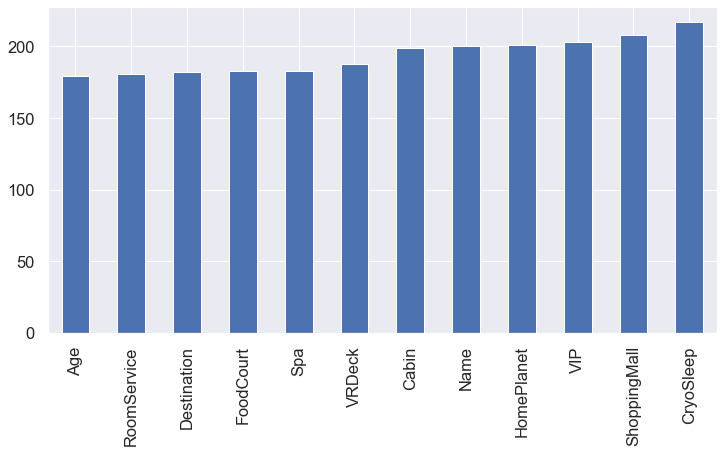

In [43]:
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(figsize = (12,6))

### Skewness (비대칭도) 확인

In [44]:
for col in numerical_feats:
    print('{:15}'.format(col),
          'Skewness: {:05.2f}'.format(df_train[col].skew()),
          '  ',
          'Kurtosis: {:06.2f}'.format(df_train[col].kurt()))

Age             Skewness: 00.42    Kurtosis: 000.10
RoomService     Skewness: 06.33    Kurtosis: 065.27
FoodCourt       Skewness: 07.10    Kurtosis: 073.31
ShoppingMall    Skewness: 12.63    Kurtosis: 328.87
Spa             Skewness: 07.64    Kurtosis: 081.20
VRDeck          Skewness: 07.82    Kurtosis: 086.01
Transported     Skewness: -0.01    Kurtosis: -02.00


# EDA

### Numerical Data 탐색

#### Correlation Heat Map

<AxesSubplot:title={'center':'Correlation of Numeric Features with Sale Price'}>

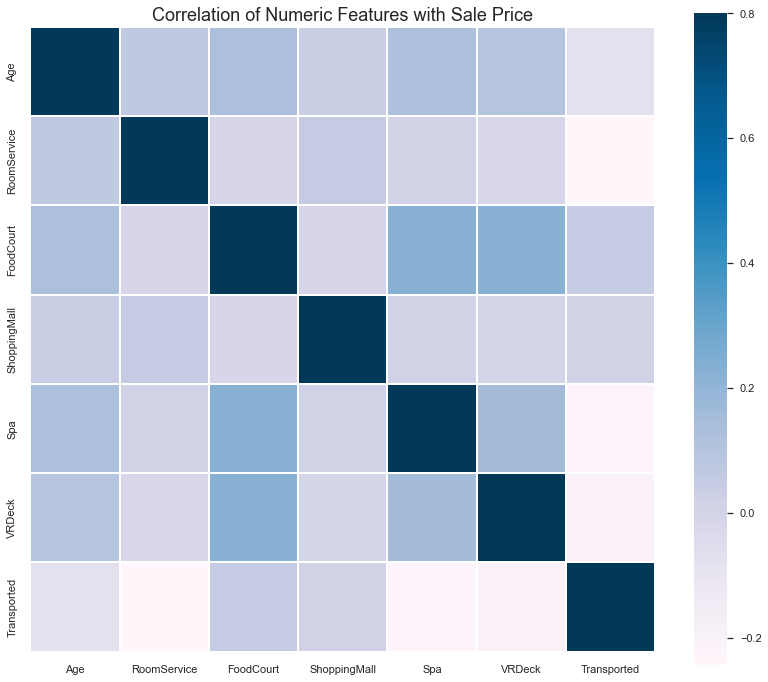

In [45]:
corr_data = df_train[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported']]
colormap = plt.cm.PuBu
sns.set(font_scale=1.0)

f, ax = plt.subplots(figsize = (14, 12))
plt.title('Correlation of Numeric Features with Sale Price', y = 1, size = 18)
sns.heatmap(corr_data.corr(), square = True, linewidths = 0.1, cmap = colormap, linecolor = 'white', vmax=0.8)

#### Zoomed Heat Map

ValueError: object arrays are not supported

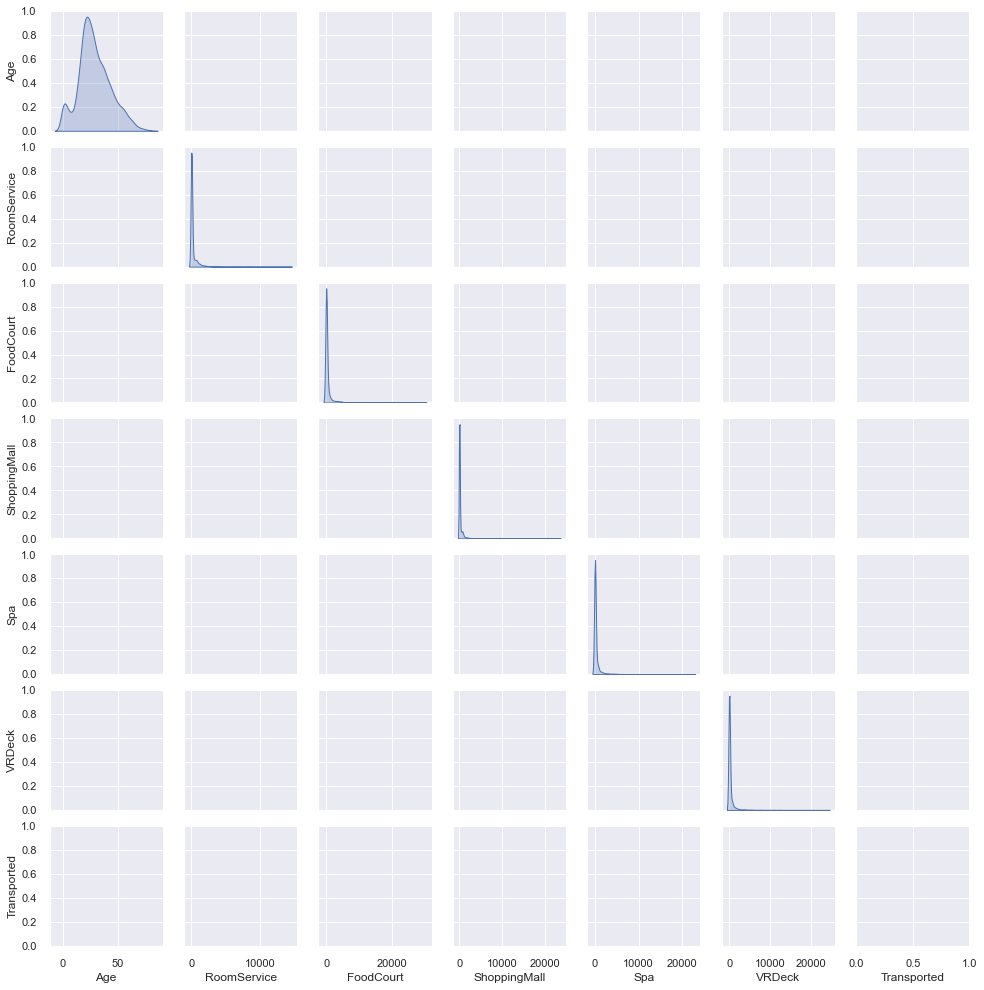

In [47]:
sns.set()
columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported']
sns.pairplot(df_train[columns], size=2, kind='scatter', diag_kind='kde')
plt.show()